# Bias in Face Recognition

In this notebook we'll demonstrate the not-so-surprising fact that if your training data has few samples of some groups, the performance of your model on these groups would be worse than the general performance. 

The notebook is based on the [Face Recognition example in ScikitLearn](https://scikit-learn.org/0.16/auto_examples/applications/face_recognition.html), using the Labeled Faces in the Wild (LFW) people dataset. Rather than predicting who's in the image, we will try to predict the gender of that person. 

We will show that given there are less females in the dataset, the model's performance on females is worse. For the sake of this example, we assume binary gender and "guess" a person's gender from their first name.

In [331]:
import os 
import math
import logging

import random
random.seed(1234)

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import gender_guesser.detector as gender

from time import time
from collections import defaultdict

from sklearn.datasets import fetch_lfw_people
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Preprocessing

Download the data, if not already on disk and load it as numpy arrays. 

In [332]:
lfw_people = fetch_lfw_people(resize=0.4, min_faces_per_person=20)

n_samples, h, w = lfw_people.images.shape
X_name = lfw_people.data
n_features = X_name.shape[1]

# the label to predict is the id of the person
y_name = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 3023
n_features: 1850
n_classes: 62


Next, we use a "gender guesser" to assign a gender label for each person in the dataset, disregarding people with gender-neutral names.

In [333]:
gender_detector = gender.Detector()
genders = {name: gender_detector.get_gender(name.split()[0]) for name in target_names}

males = [name for name, gender in genders.items() if gender == 'male']
females = [name for name, gender in genders.items() if gender == 'female']

# Count the number of total samples per gender
samples_per_person = defaultdict(int)

for label in y_name.tolist():
    samples_per_person[target_names[label]] += 1
    
percent = {}
for curr_gender in ['male', 'female', 'unknown']:
    curr_names = [name for name, g in genders.items() if g == curr_gender]
    curr_n_samples = sum([samples_per_person[name] for name in curr_names])
    percent[curr_gender] = curr_n_samples * 100.0 / n_samples
    
print('Estimated: males = {:.2f}%, females = {:.2f}%, unknown = {:.2f}%'.format(percent['male'], 
                                                                                percent['female'], 
                                                                                percent['unknown'])) 
print('==========================================================')
print('\n'.join([': '.join((name, gender)) for name, gender in list(genders.items())[:10]]))

Estimated: males = 81.77%, females = 10.19%, unknown = 6.65%
Alejandro Toledo: male
Alvaro Uribe: male
Amelie Mauresmo: female
Andre Agassi: male
Angelina Jolie: female
Ariel Sharon: male
Arnold Schwarzenegger: male
Atal Bihari Vajpayee: unknown
Bill Clinton: male
Carlos Menem: male


Unsurprisingly there is more representation for males than for females in the dataset. Let's convert the labels to gender labels, and reduce the number of females even further.

In [334]:
target_classes = ['male', 'female']
male_examples = [X_name[i, :] 
                 for i in range(X_name.shape[0]) 
                 if genders.get(target_names[y_name[i]], None) == 'male']
                 
female_examples = [X_name[i, :] 
                  for i in range(X_name.shape[0]) 
                  if genders.get(target_names[y_name[i]], None) == 'female'][:len(male_examples) // 10]

X = np.vstack(male_examples + female_examples)
y = np.array([0] * len(male_examples) + [1] * len(female_examples))
assert(y.shape[0] == X.shape[0])

n_samples = X.shape[0]

percent = {}
for curr_gender, curr_samples in zip(['male', 'female'], [male_examples, female_examples]):
    percent[curr_gender] = len(curr_samples) * 100.0 / n_samples
    
print(f'n_samples: {n_samples}')
print('Estimated: males = {:.2f}%, females = {:.2f}%'.format(percent['male'], percent['female'])) 

n_samples: 2719
Estimated: males = 90.92%, females = 9.08%


Let's print some people's images along with their guessed gender, to make sure we didn't mess up.

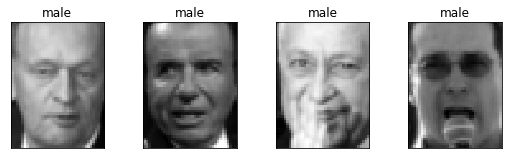

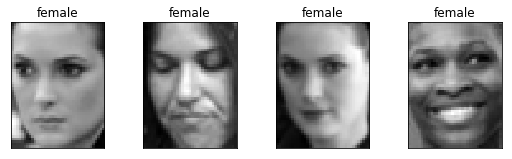

In [335]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=0.35)
    for i in range(n_row * n_col):
        if i == len(images):
            break
            
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(male_examples[:4], ['male'] * 4, h, w)
plot_gallery(female_examples[:4], ['female'] * 4, h, w)

Looks good. 

## Training

Split into a training set and a test set, and make sure they contain exactly the same classes.

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
while set(y_train) != set(y_test):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Train a simple MLP classifier with 2 hidden layers. 

In [337]:
print("Fitting the classifier to the training set")
t0 = time()
clf = MLPClassifier(hidden_layer_sizes=(n_features, n_features//2), random_state=1)
clf.fit(X, y)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 65.982s


## Evaluation 

Here we follow the same evaluation from the original example and compute the $F_1$ score across the entire test set. 

In [338]:
y_pred = clf.predict(X_test)
assert(y_pred.shape[0] == y_test.shape[0])
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}'.format(precision, recall, f1)) 

precision = 0.947, recall = 0.938, f1 = 0.941


## Fairness Evaluation

Overall the performance is really good at $F_1 = 0.94$. 
Now, let's find out how the performance differs between males and females.

In [339]:
print(classification_report(y_test, y_pred, target_names=target_classes))

              precision    recall  f1-score   support

        male       0.98      0.95      0.97       247
      female       0.62      0.80      0.70        25

   micro avg       0.94      0.94      0.94       272
   macro avg       0.80      0.88      0.83       272
weighted avg       0.95      0.94      0.94       272



We can see that indeed the performance is worse than average for females. To look at specific errors, we can print people's images with their gold and predicted labels.

In [340]:
def plot_gender(gender):
    samples = [i for i in range(y_test.shape[0])
               if target_classes[y_test[i]] == gender]
    
    if len(samples) > 12:
        samples = samples[:12]
    
    curr_y_pred = [y_pred[i] for i in samples]
    curr_y_test = [y_test[i] for i in samples]
    curr_target_names = [target_names[y_test[i]] for i in samples]
    curr_X_test = [X_test[i] for i in samples]
    
    prediction_titles = ['gold: {gold}\npredicted: {pred}'.format(
        pred=target_classes[y_pred[i]], gold=target_classes[y_test[i]]) 
                         for i in samples]
    
    plot_gallery(curr_X_test, prediction_titles, h, w)
    plt.show()

Male:



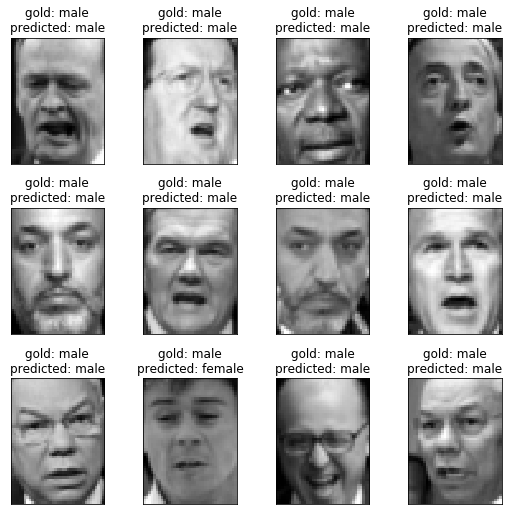

In [341]:
print('Male:\n')
plot_gender('male')   

Female:



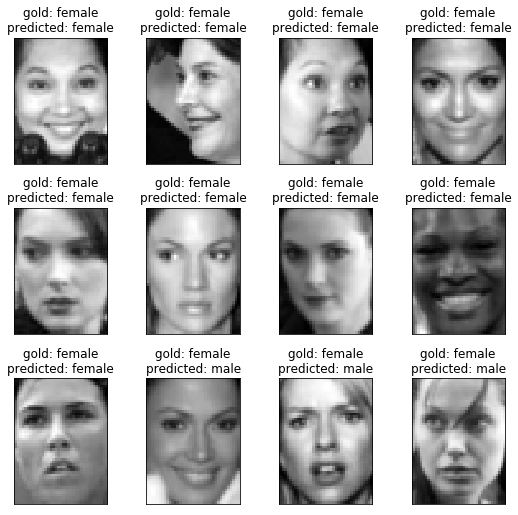

In [342]:
print('Female:\n')
plot_gender('female')  

To sum up, we saw that the model's performance on the average case can be misleading. This is a well-known problem in machine learning: less represented groups in the training data entails worse performance on these groups. The problem starts when we deal with people. And when such models are deployed in large scale, it leads to discrimination against people based on gender, race, etc. Although we deliberately created a very skewed dataset for this example, similar things happen all the time in real-world applications. 